In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [ ]:
np.random.seed(11)
data = pd.read_csv("CryptoData.csv")
print(data.head(0))
data = data.loc[:,['date','high','low','open','Volume XRP','Volume USDT','close']]
print(data.head(5))
print(data.date)

Empty DataFrame
Columns: [unix, date, symbol, open, high, low, close, Volume XRP, Volume USDT]
Index: []
         date    high     low    open   Volume XRP   Volume USDT   close
0  12-27-2021  0.9237  0.9200  0.9200    2384512.0  2.198450e+06  0.9226
1  12-26-2021  0.9334  0.9052  0.9252  163438501.0  1.499400e+08  0.9200
2  12-25-2021  0.9350  0.8981  0.9114  250074945.0  2.302303e+08  0.9252
3  12-24-2021  0.9966  0.8964  0.9941  567234092.0  5.377035e+08  0.9115
4  12-23-2021  1.0167  0.9372  0.9538  479436230.0  4.729372e+08  0.9941
0       12-27-2021
1       12-26-2021
2       12-25-2021
3       12-24-2021
4       12-23-2021
           ...    
1329      5-8-2018
1330      5-7-2018
1331      5-6-2018
1332      5-5-2018
1333      5-4-2018
Name: date, Length: 1334, dtype: object


In [ ]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2021-12-27', '2021-12-26', '2021-12-25', '2021-12-24',
               '2021-12-23', '2021-12-22', '2021-12-21', '2021-12-20',
               '2021-12-19', '2021-12-18',
               ...
               '2018-05-13', '2018-05-12', '2018-05-11', '2018-05-10',
               '2018-05-09', '2018-05-08', '2018-05-07', '2018-05-06',
               '2018-05-05', '2018-05-04'],
              dtype='datetime64[ns]', name='date', length=1334, freq=None)


In [ ]:
aim = 'close'

In [ ]:
train_data = data.iloc[200:]
test_data = data.iloc[:200]

def double_line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

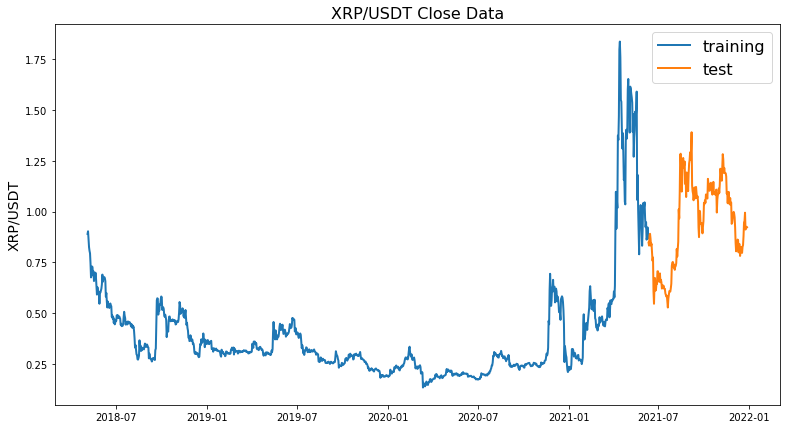

In [ ]:
double_line_plot(train_data[aim], test_data[aim], 'training', 'test', title='XRP/USDT Close Data')

In [ ]:
def normalize_zero_base(df):
    return df / df.iloc[0] - 1

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalize_zero_base(tmp)
        window_data.append(tmp.values)

    return np.array(window_data)

def prepare_data(df, aim, window_len=10, zero_base=True):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
window_len = 7
zero_base = True
lstm_neurons = 30
epochs = 25
batch_size = 25
loss = 'mse'
dropout = 0.25
optimizer = 'adam'

In [ ]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base)

In [ ]:
print(X_train.shape)

(1127, 7, 6)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [ ]:
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/25
46/46 [==============================] - 3s 16ms/step - loss: 0.0325 - val_loss: 0.0109
Epoch 2/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0048
Epoch 3/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0043
Epoch 4/25
46/46 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 5/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 6/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 7/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 8/25
46/46 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 9/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 10/25
46/46 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 11/25
46/46 

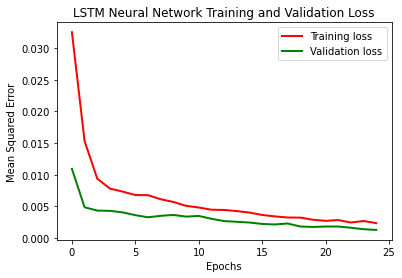

In [ ]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Network Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.025704683058830384

In [ ]:
SCORE_MSE=mean_squared_error(preds, y_test)
print(SCORE_MSE)

0.001261081217061476


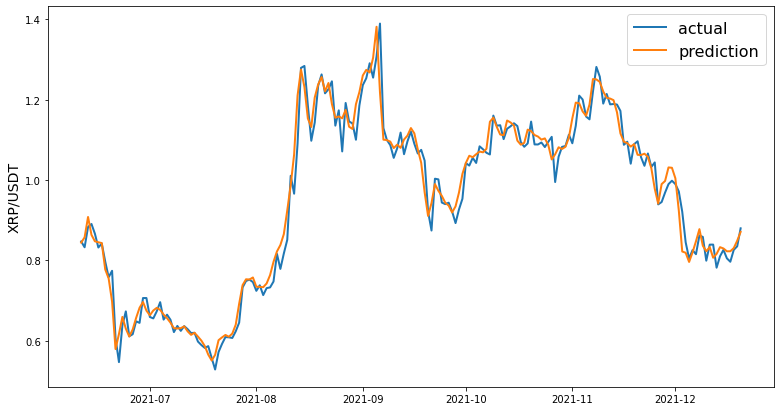

In [ ]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
double_line_plot(targets, preds, 'actual', 'prediction', lw=2)